## 4. Evaluation Metrics for Classification

In the Classification modeule #3 session trained a model for predicting churn. How do we know if it's good?

### 4.1 Evaluation metrics: session overview
- Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
- https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/refs/heads/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

!wget $data -O customer_churn_data.csv

In [100]:
df = pd.read_csv('customer_churn_data.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [101]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [102]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [103]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [104]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.801277501774308)

### 4.2 Accuracy and dummy model
- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In our previous calculations we used 0.5 as a threshold to check how many predictions were correct. Now lets check if 0.5 was the correct value or if any other value would have been better

In [105]:
threshold = np.linspace(0,1,21)
threshold

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [106]:
scores = []
for t in threshold:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' %(t,score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.598
0.15 0.664
0.20 0.707
0.25 0.737
0.30 0.759
0.35 0.766
0.40 0.780
0.45 0.793
0.50 0.801
0.55 0.798
0.60 0.797
0.65 0.784
0.70 0.765
0.75 0.744
0.80 0.730
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


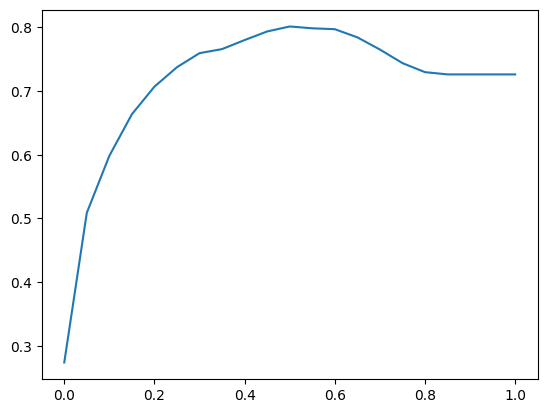

In [107]:
plt.plot(threshold,scores)

It turns out that the threshold of 0.5 was the best threshold

We can use the accuracy score from scikit-learn's library to calculate the accuracy score 

In [108]:
from sklearn.metrics import accuracy_score

In [109]:
accuracy_score(y_val, y_pred >= 0.5)

0.801277501774308

In [110]:
scores = []
for t in threshold:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' %(t,score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.598
0.15 0.664
0.20 0.707
0.25 0.737
0.30 0.759
0.35 0.766
0.40 0.780
0.45 0.793
0.50 0.801
0.55 0.798
0.60 0.797
0.65 0.784
0.70 0.765
0.75 0.744
0.80 0.730
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [111]:
from collections import Counter

In [112]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [113]:
Counter(y_val >= 1.0)

Counter({np.False_: 1023, np.True_: 386})

### Confusion Table
- Different types of errors and correct decisions
- Arranging them in a table

In [114]:
actual_posivite = (y_val ==1)
actual_negative = (y_val ==0)

In [115]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred <t)

In [116]:
tp = (predict_positive & actual_posivite).sum()

In [117]:
tn = (predict_negative & actual_negative).sum()
tn

np.int64(915)

In [118]:
fp = (predict_positive & actual_negative).sum()
fp

np.int64(108)

In [119]:
fn = (predict_negative & actual_posivite).sum()
fn

np.int64(172)

In [120]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[915, 108],
       [172, 214]])

### 4.4 Precision and Recall

In [121]:
Accuracy = (tp + tn) / (tp, tn, fp, fn)
Accuracy

array([ 5.27570093,  1.23387978, 10.4537037 ,  6.56395349])

In [122]:
# Fraction of positive predictions that are correct
precision = tp / (tp + fp)
precision

np.float64(0.6645962732919255)

In [123]:
# fraction of corectly identified positive examples (fraction of customers that we identified correctly over all the correct ones)  
recall = tp / (tp + fn)
recall

np.float64(0.5544041450777202)

In our dataset where we want to avoid churning customers.
- With precision at 66%, there are 33% users that we are wrongly sending the promotional email 
- With recall at 55%, there are 45% that we not identifying as churning so we may lose these customers
- So even though our accuracy was 80% doesn't mean our model was doing what we expected it to

### 4.5 ROC Curves: Receiver Operating Characteristic) 
The curve is a graphical plot that shows the performance of a binary classifier at various threshold settings.

TPR (True Positive Rate) and FPR (False Positive Rate)

We want to minimize the FPR and maximize the TPR

In [124]:
tpr = (tp / (tp + fn))
tpr

np.float64(0.5544041450777202)

In [125]:
fpr = fp/ (fp + tn)
fpr

np.float64(0.10557184750733138)

In [126]:
scores = []
thresholds = np.linspace(0,1,101)

for t in thresholds:
    actual_posivite = (y_val ==1)
    actual_negative = (y_val ==0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred <t)

    tp = (predict_positive & actual_posivite).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_posivite).sum()

    scores.append((t, tp, tn, fp, fn))

In [127]:
scores

[(np.float64(0.0), np.int64(386), np.int64(0), np.int64(1023), np.int64(0)),
 (np.float64(0.01), np.int64(385), np.int64(120), np.int64(903), np.int64(1)),
 (np.float64(0.02), np.int64(384), np.int64(211), np.int64(812), np.int64(2)),
 (np.float64(0.03), np.int64(382), np.int64(270), np.int64(753), np.int64(4)),
 (np.float64(0.04), np.int64(380), np.int64(315), np.int64(708), np.int64(6)),
 (np.float64(0.05), np.int64(378), np.int64(339), np.int64(684), np.int64(8)),
 (np.float64(0.06), np.int64(376), np.int64(363), np.int64(660), np.int64(10)),
 (np.float64(0.07), np.int64(374), np.int64(392), np.int64(631), np.int64(12)),
 (np.float64(0.08), np.int64(371), np.int64(422), np.int64(601), np.int64(15)),
 (np.float64(0.09), np.int64(369), np.int64(454), np.int64(569), np.int64(17)),
 (np.float64(0.1), np.int64(367), np.int64(476), np.int64(547), np.int64(19)),
 (np.float64(0.11), np.int64(365), np.int64(503), np.int64(520), np.int64(21)),
 (np.float64(0.12), np.int64(363), np.int64(520),

In [128]:
columns = ['thresholds', 'tp', 'tn', 'fp', 'fn']
df_scores = pd.DataFrame(scores, columns=columns)

In [129]:
df_scores[::10]

,thresholds,tp,tn,fp,fn
0,0.0,386,0,1023,0
10,0.1,367,476,547,19
20,0.2,334,662,361,52
30,0.3,291,779,244,95
40,0.4,253,846,177,133
50,0.5,214,915,108,172
60,0.6,153,970,53,233
70,0.7,69,1009,14,317
80,0.8,5,1023,0,381
90,0.9,0,1023,0,386


In [130]:
df_scores['tpr'] = (df_scores.tp / (df_scores.tp +df_scores.fn))
df_scores['fpr'] = df_scores.fp/ (df_scores.fp + df_scores.tn)

In [131]:
df_scores[::10]

,thresholds,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,367,476,547,19,0.950777,0.534702
20,0.2,334,662,361,52,0.865285,0.352884
30,0.3,291,779,244,95,0.753886,0.238514
40,0.4,253,846,177,133,0.655440,0.173021
50,0.5,214,915,108,172,0.554404,0.105572
60,0.6,153,970,53,233,0.396373,0.051808
70,0.7,69,1009,14,317,0.178756,0.013685
80,0.8,5,1023,0,381,0.012953,0.000000
90,0.9,0,1023,0,386,0.000000,0.000000


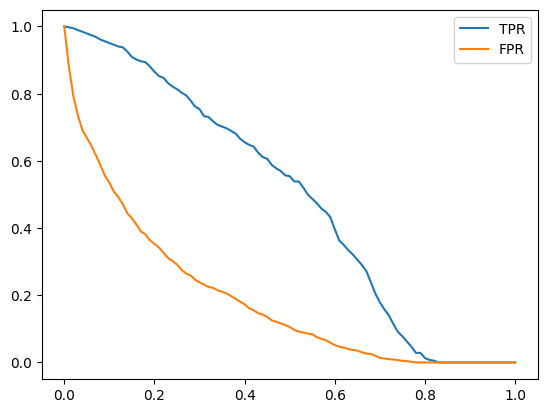

In [132]:
plt.plot(df_scores.thresholds, df_scores['tpr'], label='TPR')
plt.plot(df_scores.thresholds, df_scores['fpr'], label='FPR')
plt.legend()

### Random Model

In [133]:
np.random.seed(1)
y_rand = np.random.uniform(0,1,size=len(y_val))

In [134]:
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089], shape=(1409,))

In [135]:
((y_rand >=0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [136]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0,1,101)

    for t in thresholds:
        actual_posivite = (y_val ==1)
        actual_negative = (y_val ==0)
    
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred <t)
    
        tp = (predict_positive & actual_posivite).sum()
        tn = (predict_negative & actual_negative).sum()
    
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_posivite).sum()
    
        scores.append((t, tp, tn, fp, fn))

    columns = ['thresholds', 'tp', 'tn', 'fp', 'fn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = (df_scores.tp / (df_scores.tp +df_scores.fn))
    df_scores['fpr'] = df_scores.fp/ (df_scores.fp + df_scores.tn)

    return df_scores

In [137]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [138]:
df_rand[::10]

,thresholds,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,347,100,923,39,0.898964,0.902248
20,0.2,307,201,822,79,0.795337,0.803519
30,0.3,276,299,724,110,0.715026,0.707722
40,0.4,237,399,624,149,0.613990,0.609971
50,0.5,202,505,518,184,0.523316,0.506354
60,0.6,161,614,409,225,0.417098,0.399804
70,0.7,121,721,302,265,0.313472,0.295210
80,0.8,78,817,206,308,0.202073,0.201369
90,0.9,40,922,101,346,0.103627,0.098729


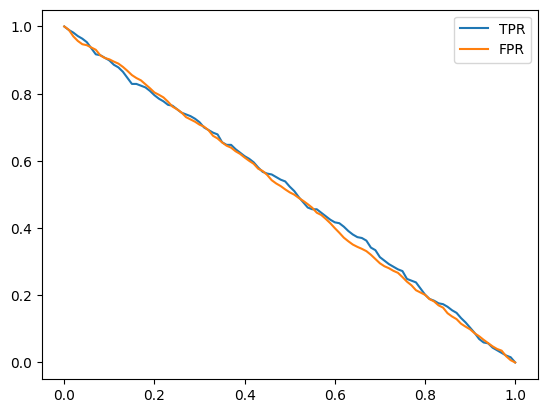

In [139]:
plt.plot(df_rand.thresholds, df_rand['tpr'], label='TPR')
plt.plot(df_rand.thresholds, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal Model

In [140]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [141]:
y_ideal = np.repeat([0,1], [num_neg, num_pos])

In [142]:
y_ideal_pred = np.linspace(0,1,len(y_val))

In [143]:
1- y_val.mean()

np.float64(0.7260468417317246)

In [144]:
((y_ideal_pred >= 0.726)== y_ideal).mean()

np.float64(1.0)

In [145]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

In [146]:
df_ideal[::10]

,thresholds,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,386,141,882,0,1.000000,0.862170
20,0.2,386,282,741,0,1.000000,0.724340
30,0.3,386,423,600,0,1.000000,0.586510
40,0.4,386,564,459,0,1.000000,0.448680
50,0.5,386,704,319,0,1.000000,0.311828
60,0.6,386,845,178,0,1.000000,0.173998
70,0.7,386,986,37,0,1.000000,0.036168
80,0.8,282,1023,0,104,0.730570,0.000000
90,0.9,141,1023,0,245,0.365285,0.000000


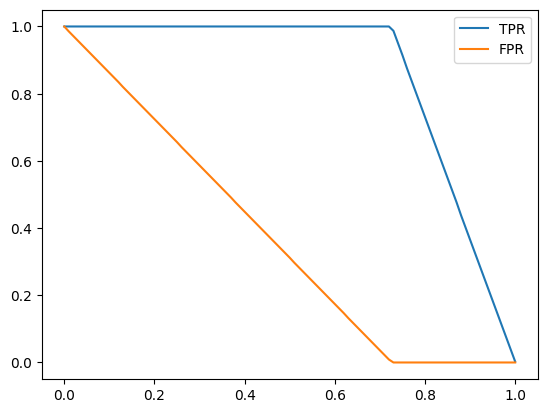

In [147]:
plt.plot(df_ideal.thresholds, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.thresholds, df_ideal['fpr'], label='FPR')
plt.legend()

### Putting everything together

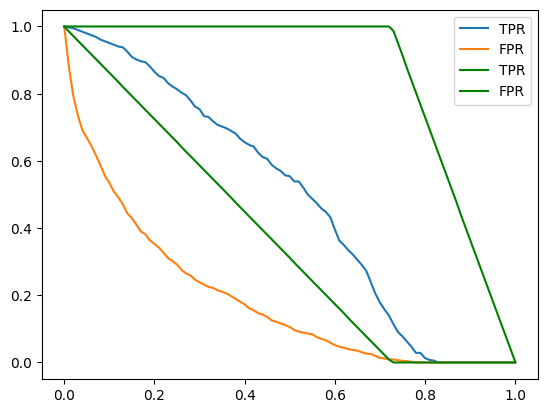

In [148]:
plt.plot(df_scores.thresholds, df_scores['tpr'], label='TPR')
plt.plot(df_scores.thresholds, df_scores['fpr'], label='FPR')

# plt.plot(df_rand.thresholds, df_rand['tpr'], label='TPR')
# plt.plot(df_rand.thresholds, df_rand['fpr'], label='FPR')

plt.plot(df_ideal.thresholds, df_ideal['tpr'], label='TPR',color='green')
plt.plot(df_ideal.thresholds, df_ideal['fpr'], label='FPR',color='green')
plt.legend()

Lets plot the TPR and FPR

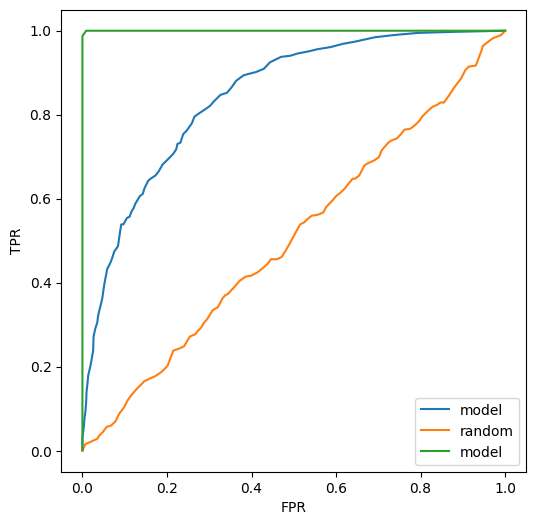

In [149]:
plt.figure(figsize=(6,6))
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='model')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

Usually for a ROC curve, we plot a random baseline i.e [0,1]

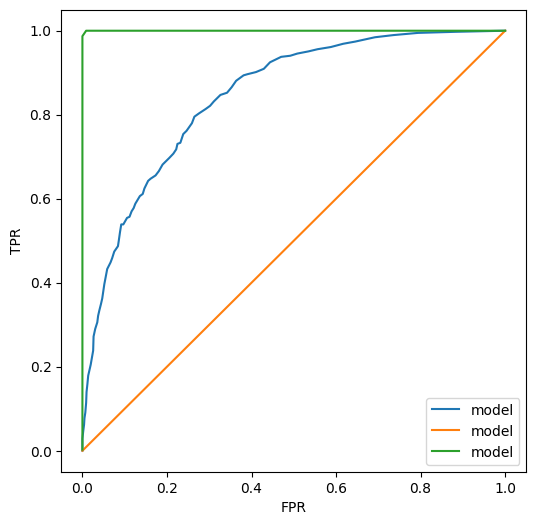

In [150]:
plt.figure(figsize=(6,6))
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1], [0,1], label='model')
# plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='model')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [151]:
from sklearn.metrics import roc_curve

In [152]:
fpr, tpr, thresh = roc_curve(y_val, y_pred)

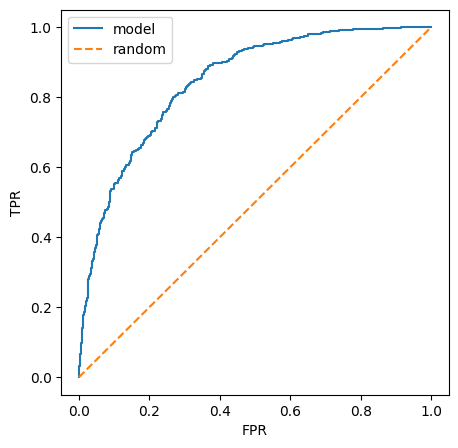

In [153]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='model')
plt.plot([0,1], [0,1], label='random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### 4.6 ROC Area Under Curve (AUC)

In [154]:
from sklearn.metrics import auc

In [155]:
auc(fpr, tpr)

0.8445038720820102

In [156]:
auc(df_scores.fpr, df_scores.tpr)

0.8443696534119398

In [157]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

We can do the followind two lines with a package:

fpr, tpr, thresh = roc_curve(y_val, y_pred)

auc(fpr,tpr)

In [158]:
from sklearn.metrics import roc_auc_score

In [159]:
roc_auc_score(y_val, y_pred)

0.8445038720820102

In [160]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [161]:
import random

In [162]:
pos_ind = random.randint(0, len(pos) -1)
neg_ind = random.randint(0, len(neg) -1)
pos_ind, neg_ind

(365, 220)

In [163]:
n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) -1)
    neg_ind = random.randint(0, len(neg) -1)

    if pos[pos_ind] > neg[neg_ind]:
        success+= 1

success/n

0.84511

In [164]:
n = 500000

pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

pos_ind, neg_ind

(array([261, 200,   9, ..., 275,  63, 220], shape=(500000,)),
 array([886, 619, 387, ..., 424, 792, 392], shape=(500000,)))

In [165]:
(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.84404)

### 4.7 Cross Validation (Paramter Tuning)
- Evaluating the same model on different dubsets of data
- Getting the average prediction and the spread within predictions

In [186]:
def train(df, y_train, C=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train, y_train)

    return dv, model

In [187]:
dv, model = train(df_train, y_train)

In [188]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [189]:
y_pred = predict(df_val, dv, model)
y_pred, len(y_pred)

(array([0.00531839, 0.15577646, 0.00424002, ..., 0.75198311, 0.03124286,
        0.00256252], shape=(1126,)),
 1126)

#### K fold cross validation

In [190]:
from sklearn.model_selection import KFold

In [191]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [192]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [193]:
len(df_full_train), len(train_idx), len(val_idx)

(5634, 5070, 564)

In [194]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

!pip install tqdm

In [195]:
from tqdm.auto import tqdm

In [196]:
y_val = df_val.churn.values
len(y_val)

564

In [197]:
y_pred = predict(df_val, dv, model)
len(y_pred)

564

In [198]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 1, 5, 10]):          
    scores = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    # Now we will loop over the indexes
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.churn.values
        y_val = df_val.churn.values
    
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('%s %.3f, +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/6 [00:00<?, ?it/s]

0.001 0.825, +- 0.009
0.01 0.840, +- 0.008
0.1 0.842, +- 0.007
1 0.842, +- 0.007
5 0.842, +- 0.007
10 0.842, +- 0.007


In [201]:
scores

[0.8439646442841331,
 0.8448115315852205,
 0.833694561509131,
 0.8348128637206625,
 0.8516441278905589]

In [200]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1)
y_pred = predict(df_test, dv, model)
auc = roc_auc_score(y_test, y_pred)
auc

0.8584032088573997